# MLClass. "Прикладной анализ данных"
# Модуль "Машинное обучение с помощью Python"
<img src="../img/mlclass_logo.jpg" height="240" width="240">
## Автор материала: преподаватель ФКН НИУ ВШЭ Кашницкий Юрий
Материал распространяется на условиях лицензии <a href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-Share Alike 4.0</a>. Можно использовать в любых целях, но с обязательным упоминанием автора курса и аффилиации.

# Урок 6. Нейронные сети. Бустинг. Смешивание алгоритмов. Стекинг.
## Часть 4.  Смешивание алгоритмов для набора данных Titanic. ROC AUC 

<a href="https://www.kaggle.com/c/titanic">Соревнование</a>.

Подключаем библиотеки

In [1]:
import pandas as pd
import numpy as np
%pylab inline
figsize(12, 8)
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split, StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import roc_auc_score
from scipy.stats.stats import pearsonr 
from load_titanic_with_features import load_titanic

Populating the interactive namespace from numpy and matplotlib


Считываем данные

In [2]:
%%time
X_train, y, X_test, = map(np.array, 
                          load_titanic("../data/titanic_train.csv",
                                   "../data/titanic_test.csv"))

CPU times: user 170 ms, sys: 5.46 ms, total: 176 ms
Wall time: 187 ms


Разобьем обучающую выборку на валидационную и проверочную (holdout) части.

In [3]:
X_valid, X_holdout, y_valid, y_holdout = train_test_split(X_train, y, 
                                                          train_size=0.8, 
                                                          random_state=13)

Для kNN отшкалируем данные

In [4]:
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)
X_valid_scaled, X_holdout_scaled, y_valid_scaled, y_holdout_scaled = \
    train_test_split(X_train_scaled, y, train_size=0.8, random_state=13)

In [5]:
shape(X_valid), shape(X_holdout)

((712, 8), (179, 8))

Напишем функцию для вывода результатов в виде, готовом для посылки на Kaggle.

In [6]:
def write_to_file(predicted_labels, filename, init_index=892):
    predicted_df = pd.DataFrame(predicted_labels,
                index = np.arange(init_index, 
                                  init_index + \
                                  X_test.shape[0]),
                columns=["Survived"])
    predicted_df.to_csv(filename, 
                        index_label="PassengerId")

## kNN

In [7]:
%%time

res = []

neighb = np.arange(1, 300)

for n in neighb:
    scores = cross_val_score(KNeighborsClassifier(n_neighbors=n), 
                            X_valid_scaled, y_valid, 
                            scoring="roc_auc",
                            cv=3)
    res.append(np.mean(scores))

CPU times: user 8.74 s, sys: 254 ms, total: 9 s
Wall time: 8.99 s


(0.85473422145214151, 17)

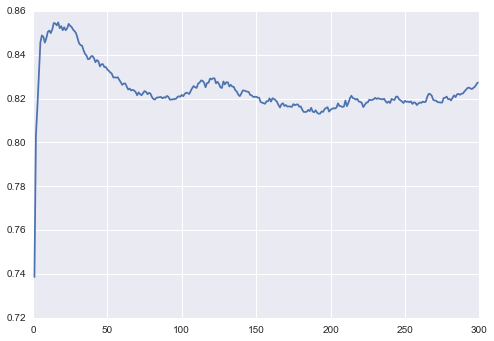

In [8]:
plot(neighb, res)
knn_valid_auc = max(res)
knn_valid_auc, neighb[np.argmax(res)]

In [9]:
thresholds = np.arange(-2.0, 2.0, 0.025)
results = []

knn = KNeighborsClassifier(n_neighbors=17)

for thres in thresholds:
    folds = StratifiedKFold(y_valid, n_folds=5, random_state=42)
    scores = []
    for train_index, test_index in folds:
        x_train, x_test = X_valid_scaled[train_index, :], \
                          X_valid_scaled[test_index, :]
        y_train, y_test = y_valid[train_index], y_valid[test_index]
        knn.fit(x_train, y_train)
        y_pred = (1 - knn.predict_proba(x_test)[:,0]
                                   >= thres).astype(int)
        if(len(np.unique(y_pred)) > 1):
            scores.append(roc_auc_score(y_pred, y_test))
        else:
            scores.append(0)
    results.append(np.mean(scores))

(0.83995350666229596, 0.64999999999999059)

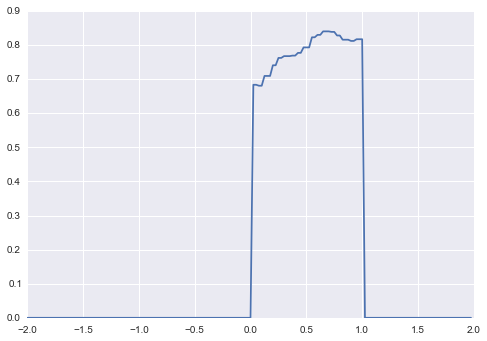

In [10]:
plot(thresholds, results)
knn_valid_thres_auc = max(results)
knn_valid_thres_auc, thresholds[np.argmax(results)]

In [12]:
print('Validation AUC with/without threshold tuning', 
      round(knn_valid_thres_auc,4),
     round(knn_valid_auc, 4))

knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(X_valid_scaled, y_valid)
knn_ho_func = 1 - knn.predict_proba(X_holdout_scaled)[:,0]
knn_ho_pred = (knn_ho_func >= 0.65).astype(int)
print('Holdout AUC with/without threshold tuning', 
      round(roc_auc_score(knn_ho_pred, y_holdout),4),
     round(roc_auc_score(knn.predict(X_holdout_scaled), y_holdout),4))

knn.fit(X_train_scaled, y)
final_knn_pred = (1 - knn.predict_proba(X_test_scaled)[:,0]
                  >= 0.65).astype(int)

Validation AUC with/without threshold tuning 0.84 0.8547
Holdout AUC with/without threshold tuning 0.8258 0.8193


In [13]:
write_to_file(final_knn_pred, '../output/titanic_knn.csv')

У такой посылки на Kaggle результат 0.77033.

## Линейный SVM

**Обучите LinearSVC с разными параметрами С на X_valid**

In [17]:
%%time

res = []

degrees = np.arange(-5., 5., 0.1)

for deg in degrees:
    scores = cross_val_score(LinearSVC(C=10 ** deg), 
                            X_valid, y_valid, 
                            scoring="roc_auc", cv=3)
    res.append(np.mean(scores))

CPU times: user 6.76 s, sys: 18.3 ms, total: 6.78 s
Wall time: 6.84 s


**Постройте график AUC на 3 подвыборках X_valid, подберите С более точно**

(0.84548267096491869, -1.0000000000000142)

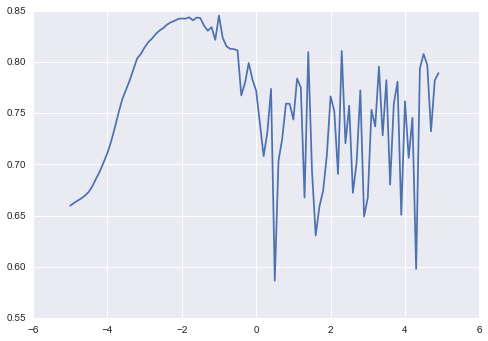

In [18]:
plot(degrees, res)
lin_svc_valid_auc = max(res)
lin_svc_valid_auc, degrees[list(res).index(max(res))]

Ищем значения параметра C в более узком диапазоне.

In [19]:
%%time

res = []

degrees = np.arange(-2, -0.5, 0.05)

for deg in degrees:
    scores = cross_val_score(LinearSVC(C=10 ** deg), 
                            X_valid, y_valid, 
                            scoring="roc_auc", cv=3)
    res.append(np.mean(scores))

CPU times: user 2.19 s, sys: 5.85 ms, total: 2.19 s
Wall time: 2.2 s


**Постройте график предсказанных значений на подвыборках X_valid**

Сохраним средний AUC в процессе кросс-валидации по X_valid в переменной *lin_svc_valid_auc*.

(0.84396930531959891, -1.7999999999999998)

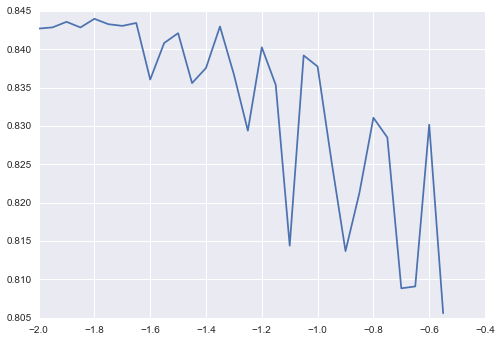

In [20]:
plot(degrees, res)
lin_svc_valid_auc = max(res)
lin_svc_valid_auc, degrees[list(res).index(max(res))]

**Подберите порог отсечения, максимизирующий AUC в процессе кросс-валидации**

In [27]:
thresholds = np.arange(-2.0, 2.0, 0.025)
results = []

lin_svc = LinearSVC(C=10 ** -1.8)

for thres in thresholds:
    folds = StratifiedKFold(y_valid, n_folds=5, random_state=42)
    scores = []
    for train_index, test_index in folds:
        x_train, x_test = X_valid[train_index, :], \
                          X_valid[test_index, :]
        y_train, y_test = y_valid[train_index], y_valid[test_index]
        lin_svc.fit(x_train, y_train)
        y_pred = (lin_svc.decision_function(x_test) 
                                   >= thres).astype(int)
        if len(np.unique(y_pred)) > 1:
            scores.append(roc_auc_score(y_pred, y_test))
        else:
            scores.append(0)
    results.append(np.mean(scores))

Сохраним средний AUC в процессе кросс-валидации по X_valid с подстройкой порога отсечения в переменной *lin_svc_valid_auc_thres*.

(0.82708301349226443, 0.29999999999999183)

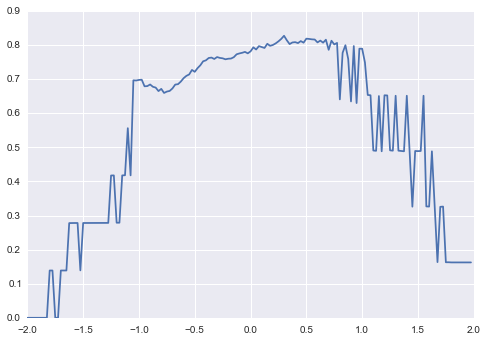

In [28]:
plot(thresholds, results)
lin_svc_valid_thres_auc = max(results)
lin_svc_valid_thres_auc, thresholds[np.argmax(results)]

**Проверьте модель на X_holdout и отправьте решение на Kaggle**

In [31]:
print('Validation AUC with/without threshold tuning', 
      round(lin_svc_valid_thres_auc,4),
     round(lin_svc_valid_auc, 4))

lin_svc = LinearSVC(C=10 ** -1.85)
lin_svc.fit(X_valid, y_valid)
lin_svc_ho_func = lin_svc.decision_function(X_holdout)
lin_svc_ho_pred = (lin_svc_ho_func >= 0.3).astype(int)
print('Holdout AUC with/without threshold tuning', 
      round(roc_auc_score(lin_svc_ho_pred, y_holdout),4),
     round(roc_auc_score(lin_svc.predict(X_holdout), y_holdout),4))

lin_svc.fit(X_train, y)
final_svc_pred = (lin_svc.decision_function(X_test) >= 0.0).astype(int)

Validation AUC with/without threshold tuning 0.8271 0.844
Holdout AUC with/without threshold tuning 0.817 0.8375


In [32]:
write_to_file(final_svc_pred, '../output/titanic_lin_svc.csv')

У такой посылки на Kaggle результат 0.77033.

## Случайный лес

**Обучите RandomForestClassifier с разными параметрами на X_valid**

In [33]:
%%time

forest_params = {'n_estimators': [10, 50, 100, 500],
                 'max_depth': list(range(1, 10, 2)),
                 'min_samples_leaf': list(range(1, 10, 2))}

locally_best_forest = GridSearchCV(RandomForestClassifier(),
                                 forest_params,
                                 verbose=True, n_jobs=4, cv=3,
                                  scoring="roc_auc")
locally_best_forest.fit(X_valid, y_valid)

res = locally_best_forest.grid_scores_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 jobs       | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done 200 jobs       | elapsed:   19.5s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   31.3s finished


CPU times: user 926 ms, sys: 187 ms, total: 1.11 s
Wall time: 31.7 s


**Постройте график AUC на 3 подвыборках X_valid, подберите параметры более точно**

Сохраним средний AUC в процессе кросс-валидации по X_valid в переменной *rf_valid_acc*.

(0.86853840010447991,
 {'max_depth': 7, 'min_samples_leaf': 3, 'n_estimators': 50},
 65)

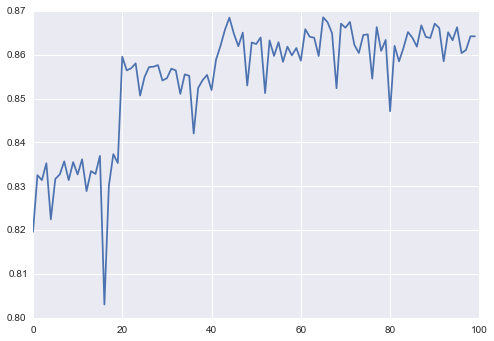

In [34]:
scores, params = [r[1] for r in res], [r[0] for r in res]
rf_valid_auc = max(scores)
plot(range(len(params)), scores)
rf_valid_auc, params[np.argmax(scores)], np.argmax(scores)

**Подберите порог отсечения, максимизирующий accuracy в процессе кросс-валидации**

In [35]:
thresholds = np.arange(0, 1.0, 0.025)
results = []

rf = RandomForestClassifier(max_depth=7,
                            min_samples_leaf=3,
                            n_estimators=50)

for thres in thresholds:
    folds = StratifiedKFold(y_valid, n_folds=5, random_state=42)
    scores = []
    for train_index, test_index in folds:
        x_train, x_test = X_valid[train_index, :], \
                          X_valid[test_index, :]
        y_train, y_test = y_valid[train_index], y_valid[test_index]
        rf.fit(x_train, y_train)
        y_pred = (1 - rf.predict_proba(x_test)[:,0] \
                                   >= thres).astype(int)
        if len(np.unique(y_pred)) > 1:
            scores.append(roc_auc_score(y_pred, y_test))
        else:
            scores.append(0)
    results.append(np.mean(scores))

Сохраним средний AUC в процессе кросс-валидации по X_valid с подстройкой порога отсечения в переменной *rf_valid_auc_thres*.

(0.85361727713845803, 0.67500000000000004)

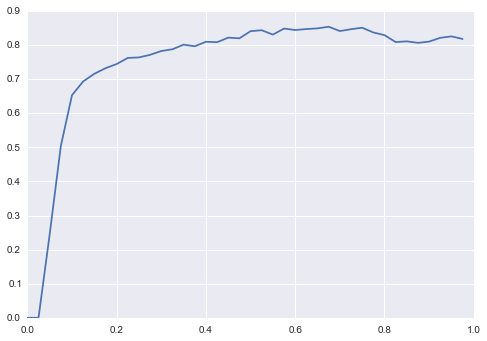

In [36]:
plot(thresholds, results)
rf_valid_auc_thres = max(results)
rf_valid_auc_thres, thresholds[np.argmax(results)]

**Проверьте модель на X_holdout и отправьте решение на Kaggle**

In [38]:
print('Validation accuracy with/without threshold tuning', 
      round(rf_valid_auc_thres, 4),
     round(rf_valid_auc, 4))

rf = RandomForestClassifier(max_depth=7,
                            min_samples_leaf=3,
                            n_estimators=50)

rf.fit(X_valid, y_valid)
rf_ho_func = 1 - rf.predict_proba(X_holdout)[:,0]
rf_ho_pred = (rf_ho_func >= 0.675).astype(int)
print('Holdout accuracy with/without threshold tuning', 
      round(roc_auc_score(rf_ho_pred, y_holdout),4),
     round(roc_auc_score(rf.predict(X_holdout), y_holdout),4))

rf.fit(X_train, y)
final_rf_pred = (1 - rf.predict_proba(X_test)[:,0] >= 0.675).astype(int)

Validation accuracy with/without threshold tuning 0.8536 0.8685
Holdout accuracy with/without threshold tuning 0.8528 0.8202


In [39]:
write_to_file(final_rf_pred, '../output/titanic_rf_tuned_50_trees.csv')

У такой посылки на Kaggle результат 0.77512.

**Посмотрите, насколько будут коррелировать предсказания  kNN, SVM и случайного леса**

In [40]:
print(pearsonr(final_rf_pred, final_svc_pred))
print(pearsonr(final_knn_pred, final_svc_pred))
pearsonr(final_knn_pred, final_rf_pred)

(0.72085777482592084, 3.1622382304773034e-68)
(0.70210678847458019, 2.480437850655147e-63)


(0.87610218216207425, 6.9799759534598684e-134)

/Users/yorko/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


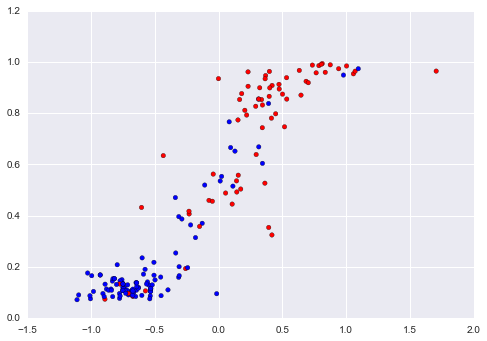

In [41]:
colors = ['red' if i else 'blue' for i in y_holdout]
scatter(lin_svc_ho_func,
     rf_ho_func, c=colors)

/Users/yorko/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


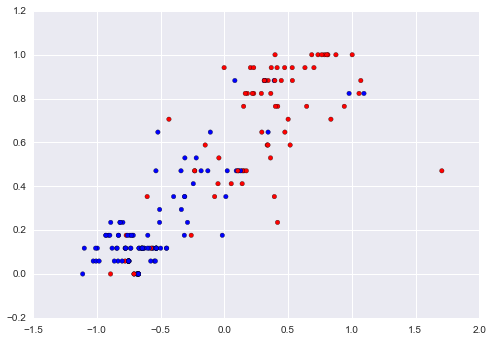

In [42]:
colors = ['red' if i else 'blue' for i in y_holdout]
scatter(lin_svc_ho_func,
     knn_ho_func, c=colors)

/Users/yorko/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


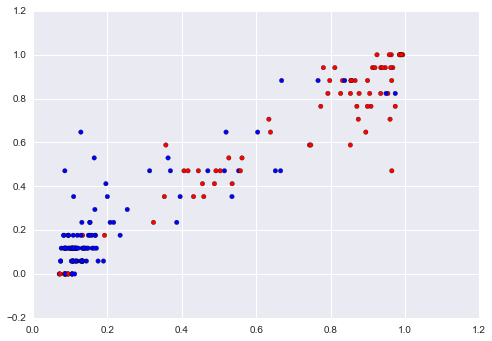

In [43]:
colors = ['red' if i else 'blue' for i in y_holdout]
scatter(rf_ho_func,
     knn_ho_func, c=colors)

## Смешивание 

**Подберите веса, с которыми будут входить предсказания kNN и обученных LinearSVC и RandomForestClassifier. Подбор проводите засчет кросс-валидации на X_valid**

In [44]:
%%time

knn = KNeighborsClassifier(n_neighbors=17)
lin_svc = LinearSVC(C=10 ** -1.85)
rf = RandomForestClassifier(max_depth=7,
                            min_samples_leaf=3,
                            n_estimators=50)

knn_weights = arange(0.0, 1.0, 0.05)
weight_triples = []

res = []

for knn_weight in knn_weights:
    for svc_weight in np.arange(0.0, 1 - knn_weight, 0.05):
        rf_weight = 1 - knn_weight - svc_weight
        weight_triples.append((knn_weight, svc_weight, rf_weight))
        folds = StratifiedKFold(y_valid, n_folds=3,
                               random_state=17)
        scores = []
        for train_index, test_index in folds:
            x_train, x_test = X_valid[train_index, :], \
                              X_valid[test_index, :]
            x_train_scaled, x_test_scaled = X_valid_scaled[train_index, :], \
                              X_valid_scaled[test_index, :]
            y_train, y_test = y_valid[train_index], y_valid[test_index]
            knn.fit(x_train_scaled, y_train)
            lin_svc.fit(x_train, y_train)
            rf.fit(x_train, y_train)
            predmix = knn_weight * (1 - 
                knn.predict_proba(x_test_scaled)[:,0] - 0.65) +\
            svc_weight * (lin_svc.decision_function(x_test)) + \
            rf_weight * (1 - rf.predict_proba(x_test)[:,0] - 0.675)

            scores.append(roc_auc_score(y_test, (predmix >= 0.0).astype(int)))
        res.append(np.mean(scores))

CPU times: user 1min 3s, sys: 456 ms, total: 1min 4s
Wall time: 1min 7s


(0.78702429338437174, (0.10000000000000001, 0.25, 0.65000000000000002), 44)

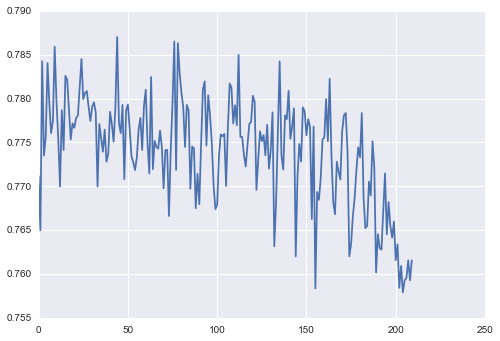

In [45]:
plot(range(len(weight_triples)), res)
mix_valid_auc = max(res)
max(res), weight_triples[np.argmax(res)], np.argmax(res)

**Проверьте модель на X_holdout и отправьте решение на Kaggle**

In [49]:
knn = KNeighborsClassifier(n_neighbors=17)
lin_svc = LinearSVC(C=10 ** -1.8)
rf = RandomForestClassifier(max_depth=7,
                            min_samples_leaf=3,
                            n_estimators=50)

knn.fit(X_valid_scaled, y_valid)
lin_svc.fit(X_valid, y_valid)
rf.fit(X_valid, y_valid)

pred_mix = (0.1 * (1 - 
                knn.predict_proba(X_holdout_scaled)[:,0] - 0.65) +\
            0.25 * (lin_svc.decision_function(X_holdout)) + \
            0.65 * (1 - rf.predict_proba(X_holdout)[:,0]
                    - 0.675) >= 0).astype(int)
print('Holdout AUC', roc_auc_score(pred_mix, y_holdout))

knn.fit(X_train_scaled, y)
lin_svc.fit(X_train, y)
rf.fit(X_train, y)

final_pred_mix = (0.1 * (1 - 
                knn.predict_proba(X_test_scaled)[:,0] - 0.65) +\
            0.25 * (lin_svc.decision_function(X_test)) + \
            0.65 * (1 - rf.predict_proba(X_test)[:,0] 
                    - 0.675) >= 0).astype(int)

Holdout AUC 0.842692422881


In [47]:
write_to_file(final_pred_mix, '../output/titanic_knn_lin_svc_rf_mix.csv')

У такой посылки на Kaggle результат 0.78469